For inference, we use simulation-based inference (SBI) with neural posterior estimation, implemented via the package [ltu-ili](https://github.com/maho3/ltu-ili).


We train a neural density estimator to infer the neutral hydrogen fraction directly from the power spectrum:  
$$
p(x_{\mathrm{HI}} \mid p_k)
$$

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import sys
from corner import corner

sys.path.append('/work/dante/scripts/ska_summer_school/21cmPipeline')


## Prepare the Dataset

In [2]:
xH_prior = np.load('/work/dante/scripts/ska_summer_school/21cmPipeline/sdc/ska_summer_school/dataset/xH_z678.npy')

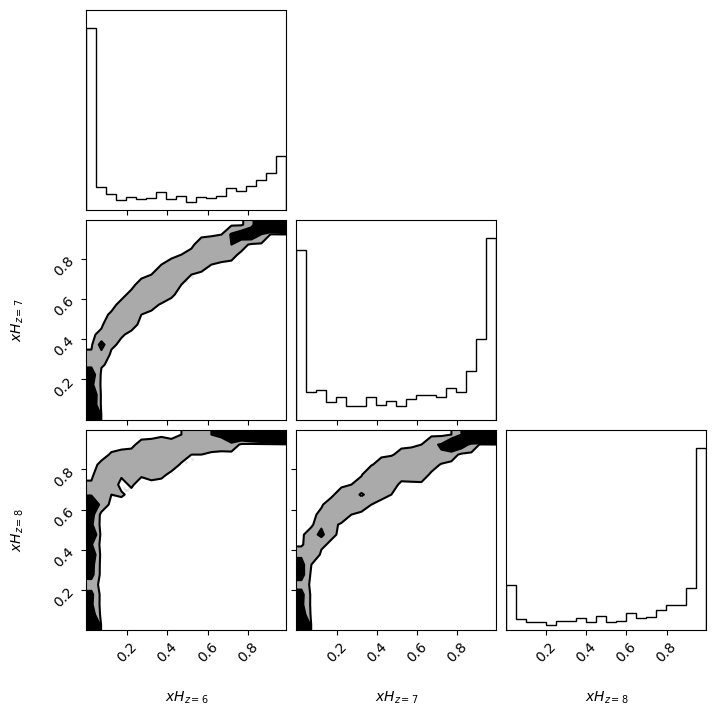

In [3]:
fig = corner(xH_prior, labels=[r'$xH_{z=6}$', r'$xH_{z=7}$', r'$xH_{z=8}$'], show_titles=False, title_kwargs={"fontsize": 12}, fill_contours=True, levels=(0.68, 0.99), plot_datapoints=True, color='black', alpha=0.5,label = 'Prior');

In [4]:
ps2d_train = np.load('/work/dante/scripts/ska_summer_school/21cmPipeline/sdc/ska_summer_school/dataset/ps2d_norm_at_mink.npy')
test_ps1 = np.load('/work/dante/scripts/ska_summer_school/21cmPipeline/sdc/ska_summer_school/dataset/test_data_1_norm_at_mink.npy')
test_ps2 = np.load('/work/dante/scripts/ska_summer_school/21cmPipeline/sdc/ska_summer_school/dataset/test_data_2_norm_at_mink.npy')

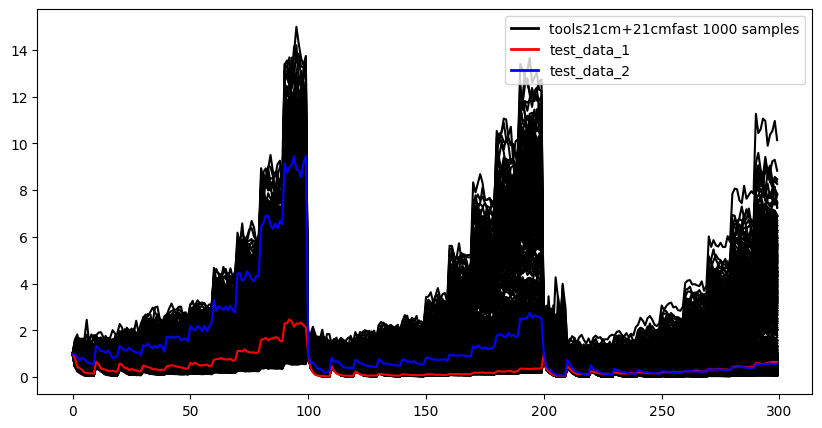

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(ps2d_train.T, label='ps2d_all',color='black')
plt.plot(test_ps1, label='test_data_1', color='red')
plt.plot(test_ps2, label='test_data_2', color='blue' );
legend_handles = [plt.Line2D([0], [0], color='black', lw=2, label='tools21cm+21cmfast 1000 samples'),
                    plt.Line2D([0], [0], color='red', lw=2, label='test_data_1'),
                    plt.Line2D([0], [0], color='blue', lw=2, label='test_data_2')]
plt.legend(handles=legend_handles, loc='upper right')

## Infer xH from PS directly

In [6]:
data = ps2d_train
params = xH_prior

Split data into training set and test set

In [7]:
from sklearn.model_selection import train_test_split

data_train, data_test, params_train, params_test = train_test_split(data, params, test_size=0.1, random_state=0)

In [8]:
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

import torch

/home/dante/.conda/envs/ska/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
device = 'cpu'# 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cpu


Define the NPE model: we use an ensemble of 10 Masked Autoregressive Flows (MAF).

In [12]:
loader = NumpyLoader(x=data_train, theta=params_train)

# define a prior
prior = ili.utils.Uniform(low=np.zeros(3),high=np.ones(3), device=device)

# instantiate your neural networks to be used as an ensemble
num_models = 10
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=50, num_transforms=5) for _ in range(10)
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-4
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
    proposal=None,
    out_dir=None
)


In [13]:
# train the model
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 10.


 Training neural network. Epochs trained: 141

INFO:root:Training model 2 / 10.


 Training neural network. Epochs trained: 136142 epochs.

INFO:root:Training model 3 / 10.


 Neural network successfully converged after 211 epochs.

INFO:root:Training model 4 / 10.


 Neural network successfully converged after 162 epochs.

INFO:root:Training model 5 / 10.


 Training neural network. Epochs trained: 134

INFO:root:Training model 6 / 10.


 Training neural network. Epochs trained: 164135 epochs.

INFO:root:Training model 7 / 10.


 Neural network successfully converged after 199 epochs.

INFO:root:Training model 8 / 10.


 Training neural network. Epochs trained: 136

INFO:root:Training model 9 / 10.


 Neural network successfully converged after 185 epochs.

INFO:root:Training model 10 / 10.


 Training neural network. Epochs trained: 143

/home/dante/.conda/envs/ska/lib/python3.8/site-packages/sbi/utils/posterior_ensemble.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights = torch.tensor(weights) / sum(weights)
INFO:root:It took 333.0319924354553 seconds to train models.


 Neural network successfully converged after 144 epochs.

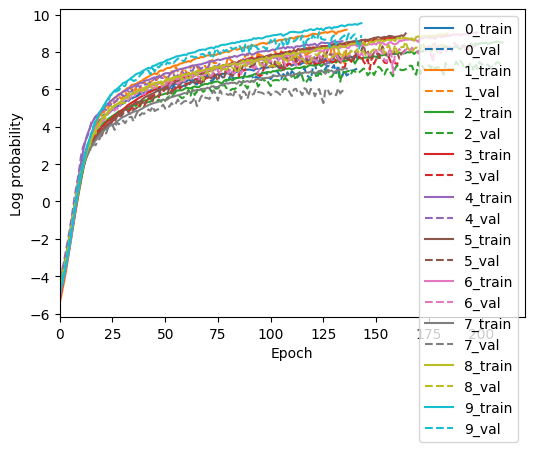

In [14]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

After training, evaluate the model on the test set by analyzing both individual posterior predictions and overall calibration performance.

Drawing 42 posterior samples: 127it [00:00, 7794.16it/s]            
Drawing 123 posterior samples: 100%|██████████| 123/123 [00:00<00:00, 14296.78it/s]
Drawing 55 posterior samples: 123it [00:00, 8552.43it/s]            
Drawing 101 posterior samples: 100%|██████████| 101/101 [00:00<00:00, 13717.53it/s]
Drawing 71 posterior samples: 153it [00:00, 10578.06it/s]           
Drawing 119 posterior samples: 100%|██████████| 119/119 [00:00<00:00, 15604.88it/s]
Drawing 121 posterior samples: 217it [00:00, 7911.79it/s]             
Drawing 14 posterior samples: 64it [00:00, 4879.85it/s]             
Drawing 224 posterior samples: 100%|██████████| 224/224 [00:00<00:00, 23445.31it/s]


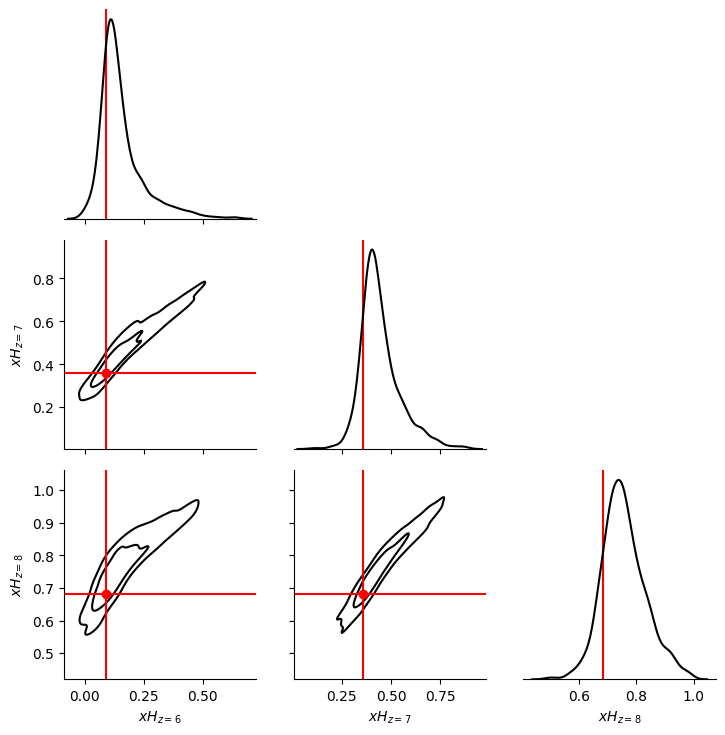

In [15]:
ind = np.random.randint(0, len(params_test))
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=[r'$xH_{z=6}$', r'$xH_{z=7}$', r'$xH_{z=8}$']
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = data_test[ind], theta_fid=params_test[ind]
)

100%|██████████| 100/100 [00:13<00:00,  7.51it/s]


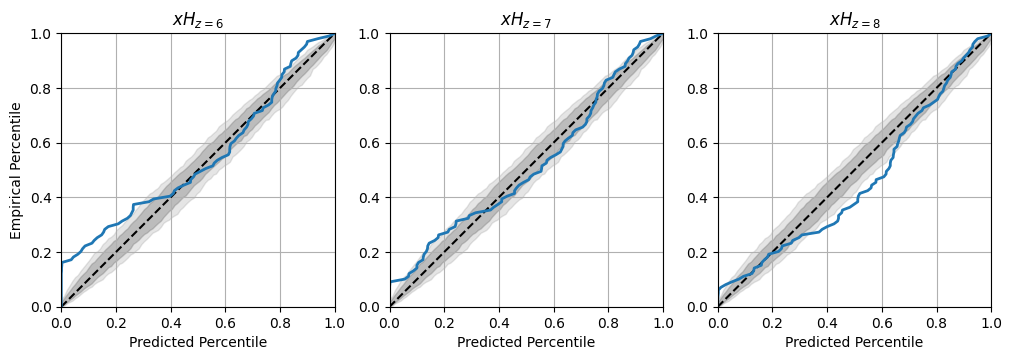

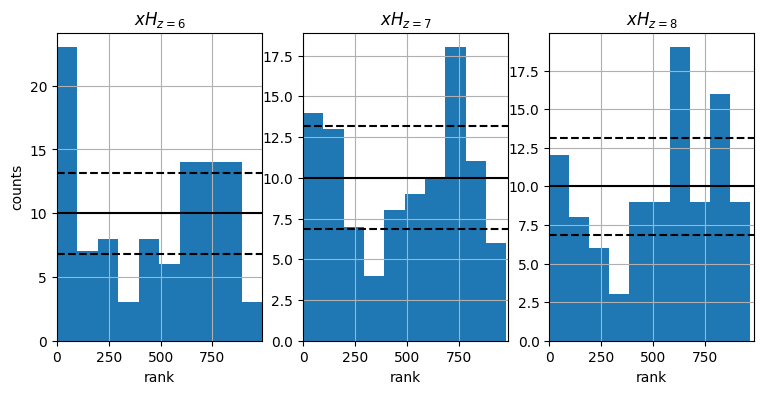

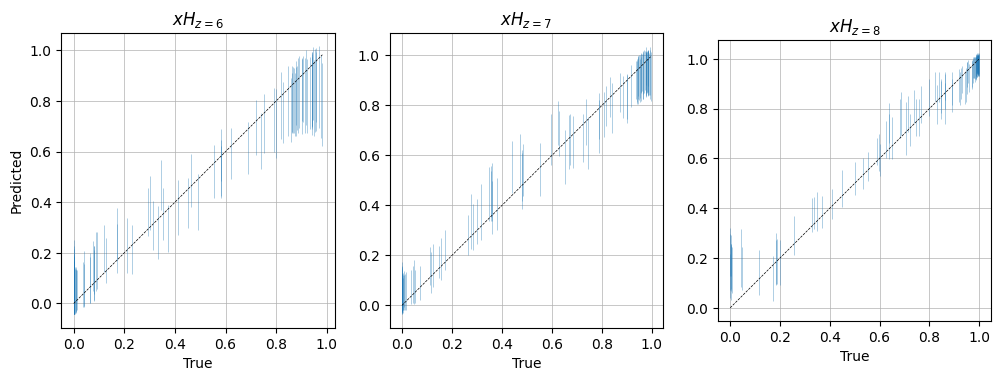

In [16]:
# Drawing samples from the ensemble posterior

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=[r'$xH_{z=6}$', r'$xH_{z=7}$', r'$xH_{z=8}$'],
    plot_list = ["coverage", "histogram", "predictions"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=data_test, theta=params_test
)

In [17]:
#save model 
torch.save(posterior_ensemble, '/work/dante/scripts/ska_summer_school/data/trained_models/model_direct_xH.pth')

Apply the model to target data

In [20]:
true_ps1_param = np.array([0.1,0.4,0.7])
true_ps2_param = np.array([0.61,0.81,0.91])

In [23]:
xH_pos_on_ps1 = posterior_ensemble.sample((10000,),x = test_ps1[None,...],show_progress_bars=False).cpu().numpy()
xH_pos_on_ps2 = posterior_ensemble.sample((10000,),x = test_ps2[None,...],show_progress_bars=False).cpu().numpy()

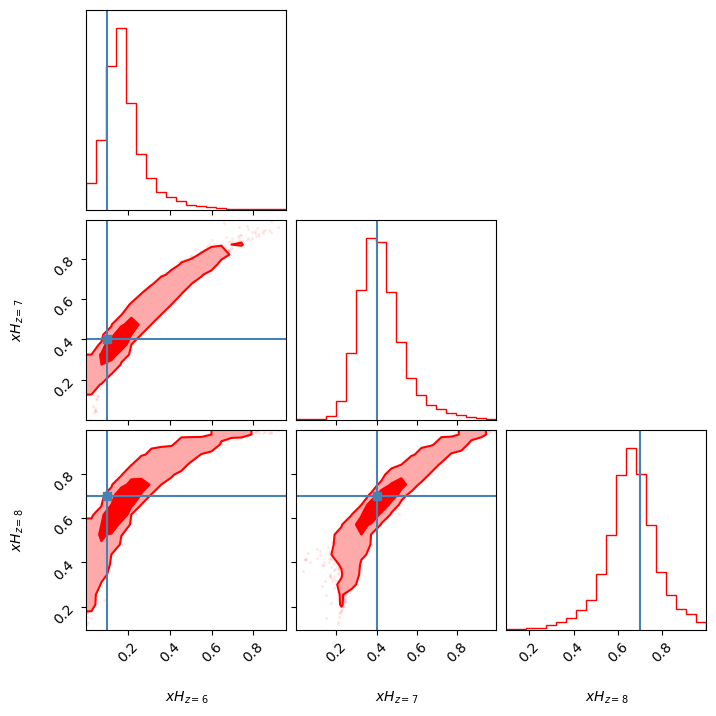

In [29]:
fig = corner(xH_pos_on_ps1, labels=[r'$xH_{z=6}$', r'$xH_{z=7}$', r'$xH_{z=8}$'], show_titles=False, title_kwargs={"fontsize": 12}, fill_contours=True, levels=(0.68, 0.99), plot_datapoints=True, color='red', alpha=0.5,label = 'Posterior',truths= true_ps1_param);

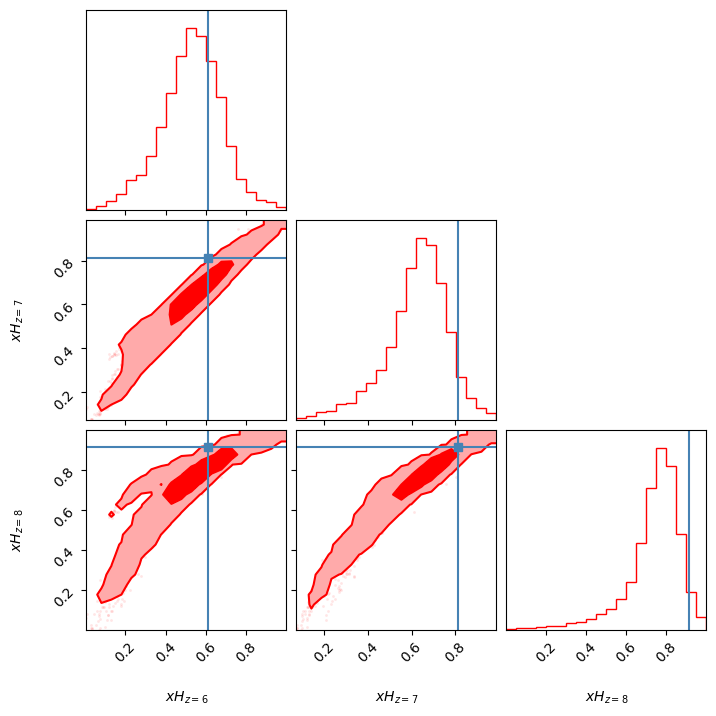

In [30]:
fig = corner(xH_pos_on_ps2, labels=[r'$xH_{z=6}$', r'$xH_{z=7}$', r'$xH_{z=8}$'], show_titles=False, title_kwargs={"fontsize": 12}, fill_contours=True, levels=(0.68, 0.99), plot_datapoints=True, color='red', alpha=0.5,label = 'Posterior',truths= true_ps2_param);